In [15]:
# 📦 Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import kagglehub

In [16]:

# 📥 Download and Inspect Dataset
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", dataset_path)

for root, dirs, _ in os.walk(dataset_path):
    print(f"\n📁 Directory: {root}")
    for d in dirs:
        print(f"   └── 📂 Sub-folder: {d}")

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset

📁 Directory: /kaggle/input/brain-tumor-mri-dataset
   └── 📂 Sub-folder: Training
   └── 📂 Sub-folder: Testing

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Training
   └── 📂 Sub-folder: pituitary
   └── 📂 Sub-folder: notumor
   └── 📂 Sub-folder: meningioma
   └── 📂 Sub-folder: glioma

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Training/pituitary

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Training/notumor

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Training/meningioma

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Training/glioma

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Testing
   └── 📂 Sub-folder: pituitary
   └── 📂 Sub-folder: notumor
   └── 📂 Sub-folder: meningioma
   └── 📂 Sub-folder: glioma

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Testing/pituitary

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Testing/notumor

📁 Directory: /kaggle/input/brain-tumor-mri-datas

In [17]:
# 🔄 Transforms
gray_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

sketch_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 📂 Custom Dual Input Dataset (Grayscale + Sketch)
class DualImageFolder(Dataset):
    def __init__(self, root, transform_gray=None, transform_sketch=None):
        self.classes = sorted(os.listdir(root))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root, class_name)
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(class_dir, fname), self.class_to_idx[class_name]))

        self.transform_gray = transform_gray
        self.transform_sketch = transform_sketch

    def __getitem__(self, index):
        path, label = self.samples[index]
        img = Image.open(path).convert("L")
        sketch_img = img.filter(ImageFilter.CONTOUR).filter(ImageFilter.EDGE_ENHANCE)

        gray_tensor = self.transform_gray(img)
        sketch_tensor = self.transform_sketch(sketch_img)

        return gray_tensor, sketch_tensor, label

    def __len__(self):
        return len(self.samples)

In [18]:
# 🔄 Dataset and Dataloaders
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

train_dataset = DualImageFolder(train_dir, gray_transform, sketch_transform)
test_dataset = DualImageFolder(test_dir, gray_transform, sketch_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("\n✅ Dataset Ready")
print("Classes:", train_dataset.classes)
print(f"Training samples: {len(train_dataset)} | Testing samples: {len(test_dataset)}")

# 🚀 Model: Dual LSTM Classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


✅ Dataset Ready
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training samples: 5712 | Testing samples: 1311


In [19]:
class DualLSTMClassifier(nn.Module):
    def __init__(self, input_size=224, hidden_size=128, num_layers=1, num_classes=4):
        super(DualLSTMClassifier, self).__init__()

        self.lstm_gray = nn.LSTM(input_size, hidden_size, num_layers,
                                 batch_first=True, bidirectional=True, dropout=0.3)

        self.lstm_sketch = nn.LSTM(input_size, hidden_size, num_layers,
                                   batch_first=True, bidirectional=True, dropout=0.3)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, gray, sketch):
        gray_seq = gray.squeeze(1)
        sketch_seq = sketch.squeeze(1)

        _, (h_gray, _) = self.lstm_gray(gray_seq)
        _, (h_sketch, _) = self.lstm_sketch(sketch_seq)

        h_combined = torch.cat([h_gray[-2], h_gray[-1], h_sketch[-2], h_sketch[-1]], dim=1)
        return self.classifier(h_combined)

In [20]:
# 🧠 Initialize Model
model = DualLSTMClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [21]:
# 🔁 Training Function with Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20):
    best_val_acc = 0
    patience = 5
    counter = 0

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for gray, sketch, labels in train_loader:
            gray, sketch, labels = gray.to(device), sketch.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(gray, sketch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        train_acc = 100 * correct / total
        avg_train_loss = running_loss / len(train_loader)

        # 🔍 Validation
        model.eval()
        val_correct, val_total, val_running_loss = 0, 0, 0.0
        with torch.no_grad():
            for gray, sketch, labels in val_loader:
                gray, sketch, labels = gray.to(device), sketch.to(device), labels.to(device)
                outputs = model(gray, sketch)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_running_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print(f"\n📌 Model saved at epoch {epoch+1} with val_acc = {val_acc:.2f}%")
        else:
            counter += 1

        if counter >= patience:
            print(f"\n⏹️ Early stopping triggered. Best Val Acc: {best_val_acc:.2f}%")
            break

        print(f"Epoch [{epoch+1}/{epochs}] ➜ Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

In [22]:
# ▶️ Start Training
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, test_loader, criterion, optimizer, device, epochs=20)


📌 Model saved at epoch 1 with val_acc = 68.34%
Epoch [1/20] ➜ Train Loss: 0.9295 | Train Acc: 62.45% | Val Acc: 68.34%

📌 Model saved at epoch 2 with val_acc = 74.29%
Epoch [2/20] ➜ Train Loss: 0.6921 | Train Acc: 73.86% | Val Acc: 74.29%
Epoch [3/20] ➜ Train Loss: 0.5900 | Train Acc: 78.17% | Val Acc: 49.50%

📌 Model saved at epoch 4 with val_acc = 75.51%
Epoch [4/20] ➜ Train Loss: 0.5287 | Train Acc: 80.43% | Val Acc: 75.51%
Epoch [5/20] ➜ Train Loss: 0.4897 | Train Acc: 82.51% | Val Acc: 68.12%
Epoch [6/20] ➜ Train Loss: 0.4531 | Train Acc: 83.60% | Val Acc: 74.29%

📌 Model saved at epoch 7 with val_acc = 80.55%
Epoch [7/20] ➜ Train Loss: 0.4424 | Train Acc: 83.75% | Val Acc: 80.55%
Epoch [8/20] ➜ Train Loss: 0.4043 | Train Acc: 85.31% | Val Acc: 65.29%
Epoch [9/20] ➜ Train Loss: 0.3861 | Train Acc: 86.55% | Val Acc: 80.24%

📌 Model saved at epoch 10 with val_acc = 82.23%
Epoch [10/20] ➜ Train Loss: 0.3723 | Train Acc: 86.68% | Val Acc: 82.23%
Epoch [11/20] ➜ Train Loss: 0.3536 | T

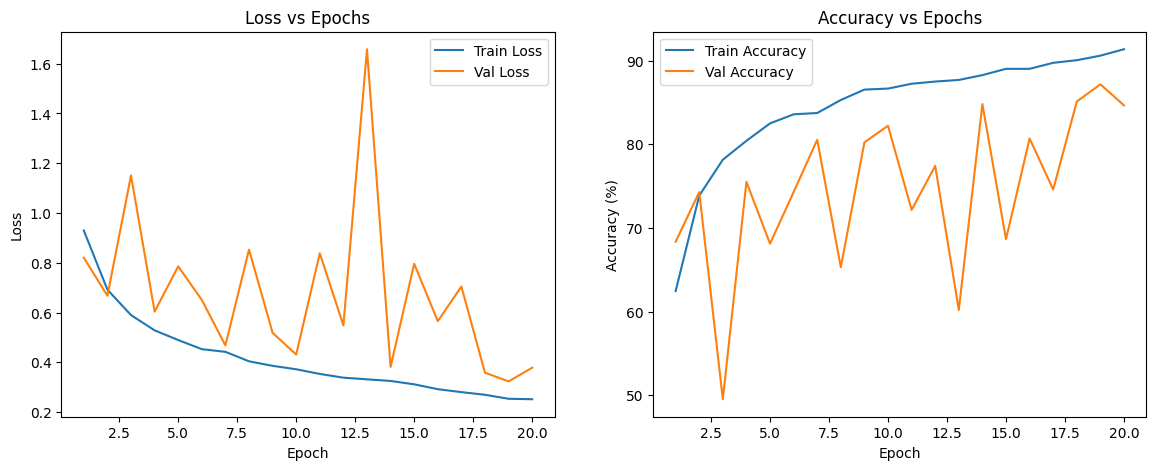

In [23]:
# 📊 Plot Training Metrics
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.show()

# 📈 Show Results
plot_metrics(train_losses, val_losses, train_accs, val_accs)